In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

from pathos.multiprocessing import ProcessPool
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import scipy as sp
import numpy as np
import torch
import tqdm
import inspect
import h5py

In [2]:
###* Create Simulator object
reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                    'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


####! bounds observables
lower_bounds = np.array([1e-8, 1e-8, 0.0, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5
                    ])

upper_bounds = np.array([5e-1, 1e-2, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0
                    ])


##! define the default parameters
params_default_norm = []
# params_default_init = np.array([
#                 0.01634, 1.67e-4, 19.75, \
#                 1.0, 1.0, 1e-2, 1e-1, 1e-1, \
#                 1e-2, 1e-1, 1e-1, 1e-1, 1e-1
#                 ])


params_default_init = np.array([
                0.02634, 7.67e-4, 10.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, \
                1e-2, 1e-1, 1e-1, 1e-1, 1e-1
                ])

params_default_norm = (params_default_init - lower_bounds) * np.reciprocal(upper_bounds - lower_bounds)

###! optimization function
def func_optimization(params_input, flag='numpy'):
    
    ##! normalize variables
    params = [0] * len(params_input)
    for idx, param in enumerate(params_input):
        params[idx] = lower_bounds[idx] + (upper_bounds[idx] - lower_bounds[idx]) * param
    
    A_d, B_d, E_d, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8, SF_9, SF_10 = params
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 31, "rate": None, "model_dict": {"SF": SF_2, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_1}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_3}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_4}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_5}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_6}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_7}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_8}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_9}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_10}},
    ]
    
    return dict_mod_vec


def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )

diff = sim_diff.SimDiff(sim, 
                        lambda params: func_optimization(params, 'torch'),
                        params_default=torch.tensor(params_default_norm),
                        gamma_exp_data=sim.gamma_exp_data_arr,
                        loss_function=lambda exp, teo: loss_function(exp, teo, 'torch')
                        )


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [3]:

###! global variables

iter_calls = 0
best_loss = float('inf')
history = {'iters':[], 'best_loss':[], 'type':[]}



In [4]:


def grads_wise_numeric(params, opt_object, hstep = 1e-5):
    
    global iter_calls
    params_arr = np.array(params)
    _, residual, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr)
    
    iter_calls += 1
    
    residuals = []
    for i in range(len(params)):
        step_vec = np.zeros_like(params_arr)
        step_vec[i] = hstep
        _, residual_plus, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr + step_vec)
        residuals.append((residual_plus-residual)/hstep)
        
        iter_calls += 1
    
    return np.array(residuals).T


def grads_wise_numeric2(params, opt_object, hstep = 1e-5):
    
    global iter_calls
    params_arr = np.array(params)
    residuals = []
    for i in range(len(params)):
        
        step_vec = np.zeros_like(params_arr)
        step_vec[i] = hstep
        
        _, residual_plus, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr + step_vec)
        _, residual_minus, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr - step_vec)
        
        residuals.append((residual_plus-residual_minus)/(2*hstep))
        iter_calls += 2
    
    return np.array(residuals).T





In [5]:


#### functions for stiff/sloppy optimization

def grads_wise(params, opt_object, diff_object):
    _, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = (opt_object.objective_function_diff(params))
    grad_val = diff_object.objective_function_grad_element_wise(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    return grad_val.detach()


def create_subspaces_num(params, percent_info, opt_object, eps = 1e-8, reg = 1e-6, tau=1e-4):
    
    grad_errors = grads_wise_numeric(params, opt_object)
    # gamma_exp = np.array(sim.gamma_exp_data_arr, dtype=grad_errors.dtype).reshape(-1, 1)
    # grad_errors = grad_errors / (gamma_exp + eps)
    norms = np.linalg.norm(grad_errors, axis=1, keepdims=True) + eps  # (n,1)
    G = grad_errors / norms                                      # (n,d)

    G = grad_errors
    F = G.T @ G                                                 # (d,d)
    F_reg = F + reg * np.eye(F.shape[0], dtype=F.dtype)
    
    eigvals, eigvecs = np.linalg.eigh(F_reg)                    # eigvals: (d,), eigvecs: (d,d)

    idx = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]
    
    total_mass = eigvals_sorted.sum()
    cumulative  = np.cumsum(eigvals_sorted)
    ks = int(np.sum(cumulative < percent_info * total_mass)) + 1
    Vs = eigvecs_sorted[:, :ks]
    
    if ks < len(eigvals_sorted):
        ratios = eigvals_sorted[ks:] / eigvals_sorted[ks]
        kl = int(np.count_nonzero(ratios >= tau))
    else:
        kl = 0
    Vl = eigvecs_sorted[:, ks:ks+kl]

    return {
        'phi0': params,
        'dims': len(eigvals_sorted),
        'V_dims': (ks, kl),
        'Vs': Vs,
        'Vl': Vl,
        'eigvals_sorted': eigvals_sorted,
        'eigvecs_sorted': eigvecs_sorted
    }


def create_subspaces(params, percent_info, opt_object, diff_object, eps = 1e-8, reg = 1e-6, tau=1e-4):
    
    grad_errors = - grads_wise(params, opt_object, diff_object)
    gamma_exp = torch.tensor(
        sim.gamma_exp_data_arr, dtype=grad_errors.dtype
    ).reshape(-1, 1)
    grad_errors = grad_errors / (gamma_exp + eps)
    norms = grad_errors.norm(dim=1, keepdim=True) + eps
    G = grad_errors / norms                 
    F  = G.T @ G                            

    F_reg = F + reg * torch.eye(F.size(0), dtype=F.dtype)
    eigvals, eigvecs = torch.linalg.eigh(F_reg) # ascending
    
    idx = torch.argsort(eigvals, descending=True)
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]
    
    ###* stiff subspace
    total_mass = eigvals_sorted.sum()
    cumulative  = torch.cumsum(eigvals_sorted, dim=0)
    ks = int((cumulative < percent_info * total_mass).sum().item()) + 1
    Vs = eigvecs_sorted[:, :ks]
    
    ###* sloppy subspace
    ratios = eigvals_sorted[ks:] / eigvals_sorted[ks]
    kl = np.count_nonzero(ratios >= tau)
    Vl = eigvecs_sorted[:, ks:ks+kl]
    
    return {
        'phi0': params,
        'dims': len(eigvals_sorted),
        'V_dims': (ks, kl),
        'Vs': Vs.cpu().numpy(),
        'Vl': Vl.cpu().numpy(),
        'eigvals_sorted': eigvals_sorted.cpu().numpy(),
        'eigvecs_sorted': eigvecs_sorted.cpu().numpy()
    }



def Phi_loss(space_string, vars_opt, opt_object, diff_objec, config, string="loss: "):
    
    if not space_string in ['Vs', 'Vl']:
        raise ValueError(f"{space_string} must be Vs or Vl")
    
    params = np.abs(config['phi0'] + config[space_string] @ vars_opt)
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    
    global iter_calls
    global best_loss
    global history
    
    iter_calls += 1
    best_loss = loss_val if loss_val < best_loss else best_loss
    
    if iter_calls % 15:
        history['iters'].append(iter_calls)
        history['best_loss'].append(best_loss)
        if space_string == 'Vs':
            history['type'].append("stiff")
        else:
            history['type'].append("sloppy")
    
    if iter_calls % 20:
        print(string, loss_val, "vars: ", vars_opt ,"iter_calls: ", iter_calls)
        
    return loss_val



class TooManyEvals(Exception):
    def __init__(self, message, value=None):
        super().__init__(message)
        self.value = value



def make_limited_fun(fun, max_calls):
    calls = {'n': 0}
    last_value = None
    def wrapped(*args, **kwargs):
        nonlocal last_value
        calls['n'] += 1
        if calls['n'] > max_calls:
            raise TooManyEvals(f"Exceeded {max_calls} function evaluations", args[1] if len(args) > 1 else None)
        return fun(*args, **kwargs)
    return wrapped




In [6]:


####* sloppy/stiff algorithm 

### hyperparameters
percent_info = 0.90
tau = 1e-4
tolerace = 1e-3 # 1e-3
max_fun_calls_sloppy = 130

config_dict_record = []
history = {'best_loss':[], "iters":[], "type":[]}

#### initialization
# config_dict = create_subspaces(params_default_norm, percent_info, optimizer, diff, tau=tau)
config_dict = create_subspaces_num(params_default_norm, percent_info, optimizer, tau=tau)

phi_prev = config_dict['phi0']
delta_phi_vec = []

nb_iter = 0
nb_max_iter = 50




In [7]:

while nb_iter < nb_max_iter:
        
        #### optimization along the stiff space
        init_vec = np.array([0.0 for _ in range(config_dict['V_dims'][0])])
        res_stiff = sp.optimize.minimize(
                lambda params: Phi_loss('Vs', params, optimizer, diff, config_dict, string="loss stiff: "),
                x0=init_vec,
                method='Powell',
                options={
                'xtol': 1e-4,     # tolerance on parameter changes
                'ftol': 1e-4,     # tolerance on function‐value changes
                'maxiter': 200, 
                'maxfev': 150   
                }
        )
        
        config_dict['phi0'] = np.abs(config_dict['phi0'] + config_dict['Vs'] @ res_stiff.x)
        
        #### optimization alon the sloppy space
        init_vec = np.array([0.0 for _ in range(config_dict['V_dims'][1])])
        wrapped_Phi_loss = make_limited_fun(Phi_loss, max_fun_calls_sloppy)
        
        try:
                res_sloppy = sp.optimize.minimize(
                        lambda params: wrapped_Phi_loss('Vl', params, optimizer, diff, config_dict, string="loss sloppy: "),
                        x0 = init_vec,
                        method='Nelder-Mead',
                        tol=5e-5,
                        options={
                                'xatol': 1e-5,
                                'fatol': 1e-5,
                                'disp': True  # (optional) shows progress
                                        }
                        )
                psi = res_sloppy.x
                
        except TooManyEvals as e:
                psi = e.value
        
        
        config_dict['phi0'] = np.abs(config_dict['phi0'] + config_dict['Vl'] @ psi)
                
        ### create the new subspace optimization
        Vs_old = config_dict['Vs']
        config_dict_record.append(config_dict)
        
        config_dict = create_subspaces_num(config_dict['phi0'], percent_info, optimizer, tau=tau)
        
        ### check stopping criteria
        M = config_dict['Vs'].T @ Vs_old
        sigmas = np.linalg.svd(M, compute_uv=False)
        delta_s = max(1-sigmas)
        
        delta_phi = np.sqrt(np.sum((config_dict['phi0'] - phi_prev)**2))
        delta_phi_vec.append(delta_phi)
        
        print("**"*50)
        print("DELTA PHI: ", delta_phi, "DELTA S: ", delta_s)
        
        
        if delta_s < tolerace:
                break
        
        nb_iter += 1
        phi_prev = config_dict['phi0']

loss stiff:  794.85475091558 vars:  [0.] iter_calls:  15
loss stiff:  794.85475091558 vars:  [0.] iter_calls:  16
loss stiff:  0.8785702351202402 vars:  [1.] iter_calls:  17
loss stiff:  0.8823100831988866 vars:  [2.618034] iter_calls:  18
loss stiff:  0.8808006428886561 vars:  [1.61803397] iter_calls:  19
loss stiff:  0.8157989322729422 vars:  [0.38196603] iter_calls:  21
loss stiff:  0.498072426861828 vars:  [0.23606799] iter_calls:  22
loss stiff:  0.12043553049672742 vars:  [0.14589804] iter_calls:  23
loss stiff:  6.891471701112987 vars:  [0.09016995] iter_calls:  24
loss stiff:  0.14465218147114078 vars:  [0.1803399] iter_calls:  25
loss stiff:  0.06000127000463811 vars:  [0.15749716] iter_calls:  26
loss stiff:  0.06184412461740991 vars:  [0.16176094] iter_calls:  27
loss stiff:  0.06195726858614581 vars:  [0.15592219] iter_calls:  28
loss stiff:  0.059545073248179384 vars:  [0.15907213] iter_calls:  29
loss stiff:  0.7471876026668145 vars:  [0.31814426] iter_calls:  30
loss sti

In [8]:
print(history.keys())

# loss sloppy:  0.04500944927353915 vars:  [-5.71834485e-05  3.06900125e-07] iter_calls:  536

dict_keys(['best_loss', 'iters', 'type'])


In [9]:

with h5py.File("sloppy_num_1e-3.h5", "w") as f:
    
    f.create_dataset("best_loss", data=history['best_loss'])
    f.create_dataset("iters", data=history['iters'])
    f.create_dataset("type", data=history['type'])


In [10]:
print(np.array(delta_phi_vec))

[2.02647895e-01 1.14818583e-02 5.29710973e-04 6.88290206e-05]


In [11]:
print(config_dict['phi0'])

[2.75443794e-07 2.45982032e-01 4.50532756e-01 9.99989302e-01
 9.99775093e-01 3.17551020e-03 9.99497950e-02 9.99846195e-02
 9.37114638e-03 1.00161785e-01 9.99995510e-02 1.00641126e-01
 9.99913243e-02]


In [12]:
print(lower_bounds + config_dict['phi0'] * (upper_bounds - lower_bounds))

[1.47721894e-07 2.45982786e-03 1.35159827e+01 9.99989302e-01
 9.99775096e-01 3.18547844e-03 9.99587956e-02 9.99936197e-02
 9.38105267e-03 1.00170783e-01 1.00008551e-01 1.00650119e-01
 1.00000324e-01]


In [13]:
print(config_dict['Vs'])

[[-3.23027211e-02]
 [-1.42011669e-01]
 [-4.20989142e-01]
 [-6.32871395e-07]
 [ 6.30572995e-07]
 [-8.95056804e-01]
 [ 1.30609898e-05]
 [ 3.56036971e-07]
 [-2.10351244e-04]
 [ 1.77426438e-02]
 [ 9.10846082e-06]
 [ 1.07626435e-02]
 [ 4.29468394e-08]]


In [14]:
print(config_dict['Vl'])

[[ 4.94603549e-02  8.33856186e-01]
 [ 2.74420680e-01  5.05615663e-01]
 [ 8.50806239e-01 -2.15945763e-01]
 [-3.14970799e-06  4.88569302e-05]
 [ 3.16156923e-06 -4.90992201e-05]
 [-4.45279978e-01 -8.47516836e-03]
 [-3.57445427e-06  1.80701209e-04]
 [ 8.94194819e-08  1.99004855e-06]
 [-3.00819568e-04  3.29503616e-03]
 [ 6.47951406e-03  3.42598967e-02]
 [ 1.14326498e-05 -1.18495809e-04]
 [ 7.70538901e-03 -3.38764261e-02]
 [ 8.99899443e-08 -1.28803258e-06]]


/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_67676/3908650110.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', mat_stiff.shape[1]) # 12 distinct colors


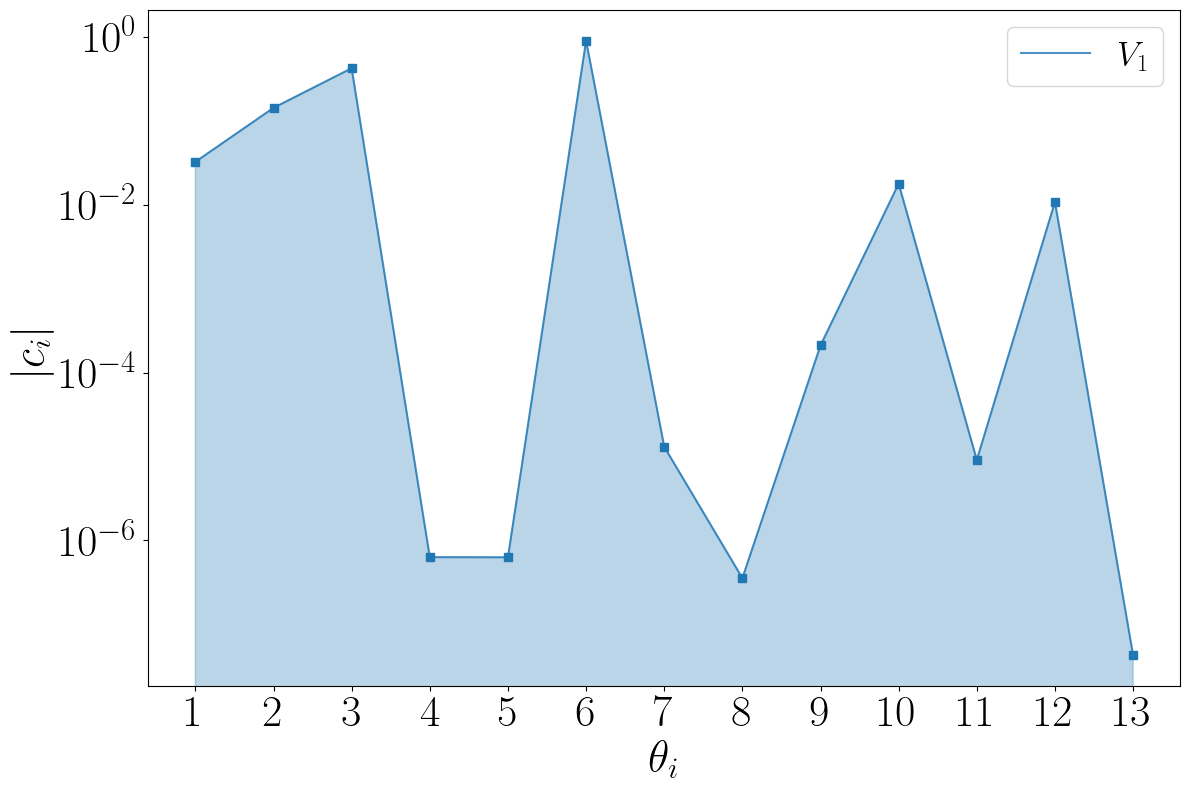

In [18]:

import matplotlib.pyplot as plt


mat_stiff = config_dict['Vs']

colors = plt.cm.get_cmap('tab20', mat_stiff.shape[1]) # 12 distinct colors

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
x = np.arange(1, mat_stiff.shape[0]+1)
y = np.abs(mat_stiff[:,0])

ax.plot(x, y, color=colors(0), alpha=0.8, label=r'$V_{'+ str(0+1)  +'}$')
ax.plot(x, y, 's', color=colors(0))
ax.fill_between(x, y, alpha=0.3, color=colors(0))

plt.xticks(x)
plt.xlabel(r'$\theta_i$', fontsize=32)
plt.ylabel(r'$|c_i|$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.legend(fontsize=25)
# plt.grid()
plt.yscale('log')
plt.tight_layout()
# plt.show()
plt.savefig("best_point_eigen_stiff.png")



/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_67676/2588243218.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', mat_sloppy.shape[1]) # 12 distinct colors


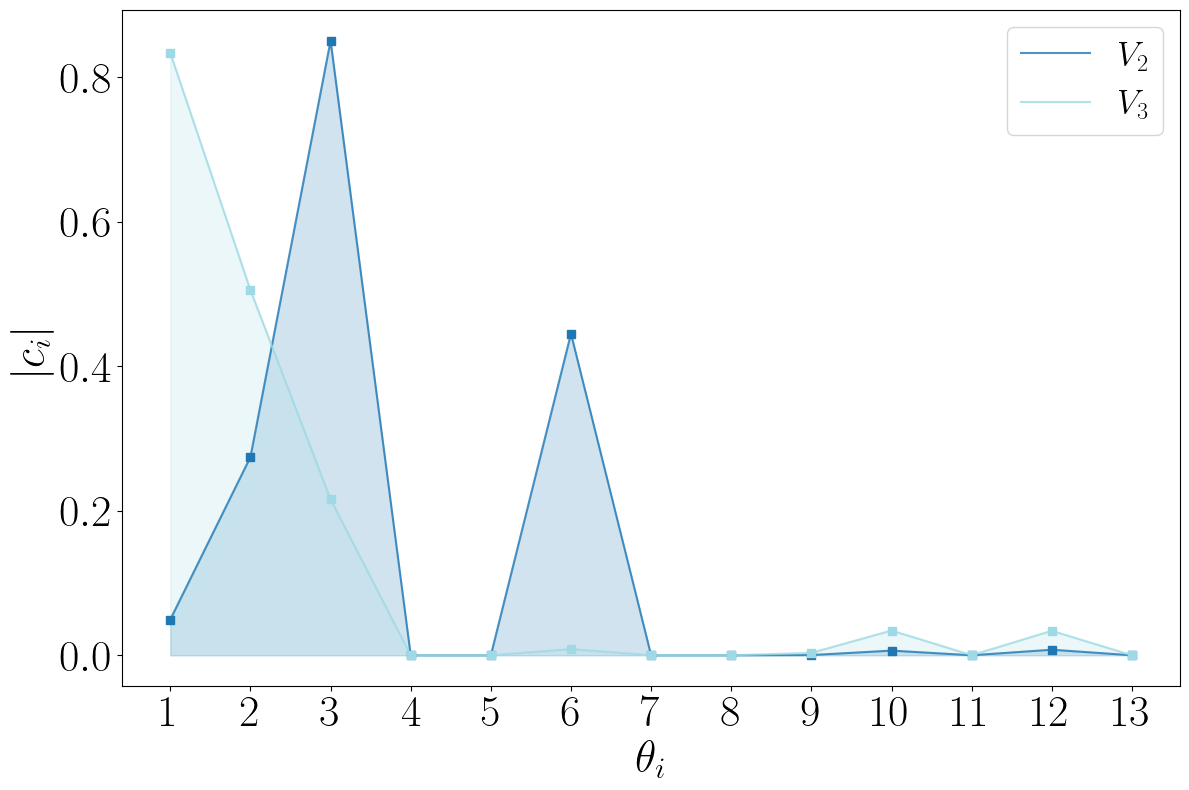

In [17]:

mat_sloppy = config_dict['Vl']
# mat_sloppy[mat_sloppy < 1e-3] = 0.0

x = np.arange(1, mat_sloppy.shape[0]+1)
data = np.abs([mat_sloppy[:,i] for i in range(mat_sloppy.shape[1])])

colors = plt.cm.get_cmap('tab20', mat_sloppy.shape[1]) # 12 distinct colors

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

for i, y in enumerate(data[:]):
    ax.plot(x, y, color=colors(i), alpha=0.8, label=r'$V_{'+ str(i+2)  +'}$')
    ax.plot(x, y, 's', color=colors(i))
    ax.fill_between(x, y, alpha=0.2, color=colors(i))

plt.xticks(x)
plt.xlabel(r'$\theta_i$', fontsize=32)
plt.ylabel(r'$|c_i|$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.legend(fontsize=25)
# plt.grid()
# plt.yscale('log')
plt.tight_layout()
# plt.show()
plt.savefig("best_point_eigen_sloppy.png")